<a href="https://colab.research.google.com/github/erickdias10/projeto-analise-sentimento/blob/main/NPL_Paris_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NPL_Paris_2024

In [1]:
# Importação das bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from imblearn.over_sampling import SMOTE
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re

In [2]:
# Baixando recursos do NLTK necessários para stopwords, tokenização e lematização
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
# 1. Carregar o Dataset
# Carregando os dados de um arquivo CSV com delimitador ';' e ignorando linhas com erros
df = pd.read_csv(
    r"/content/sample_data/paris-2024-faq.csv",
    delimiter=';',
    on_bad_lines='skip',
    engine='python'
)

In [4]:
# 2. Pré-processamento de Dados
# Função para limpar o texto, removendo números, pontuação e convertendo para minúsculas
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Aplicando a função de limpeza à coluna de texto
df['body_cleaned'] = df['body'].apply(clean_text)

# Função simples para atribuir sentimentos com base na presença de certas palavras
def assign_sentiment(text):
    if 'possible' in text:
        return 'positivo'
    else:
        return 'negativo'

# Aplicando a função de sentimento ao texto limpo
df['sentimento'] = df['body_cleaned'].apply(assign_sentiment)

# Função para preprocessar o texto: remoção de stopwords e lematização
def preprocess_text(text):
    stop_words = set(stopwords.words('portuguese'))
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# Aplicando o pré-processamento ao texto limpo
df['texto_processado'] = df['body_cleaned'].apply(preprocess_text)

In [5]:
# 3. Feature Engineering - TF-IDF
# Convertendo o texto em features numéricas usando TF-IDF
tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(df['texto_processado']).toarray()
y = df['sentimento']

In [6]:
# 4. Divisão em Treino e Teste
# Dividindo o conjunto de dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
# 5. Balanceamento de Classes usando SMOTE
# Aplicando SMOTE para balancear as classes no conjunto de treino
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

In [8]:
# 6. Treinamento do Modelo - RandomForest com GridSearch para Otimização
# Definindo o grid de hiperparâmetros para o RandomForest
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced', 'balanced_subsample', None]
}

# Realizando a busca em grade com validação cruzada
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, scoring='f1_macro', n_jobs=-1, verbose=2)
grid_search.fit(X_train_balanced, y_train_balanced)

# Selecionando o melhor modelo a partir da busca em grade
best_model = grid_search.best_estimator_

Fitting 3 folds for each of 243 candidates, totalling 729 fits


RandomForestClassifier com GridSearch
RandomForestClassifier(min_samples_split=5, random_state=42)
Accuracy: 0.9315068493150684
Classification Report:
               precision    recall  f1-score   support

    negativo       0.93      1.00      0.96       201
    positivo       1.00      0.17      0.29        18

    accuracy                           0.93       219
   macro avg       0.97      0.58      0.62       219
weighted avg       0.94      0.93      0.91       219



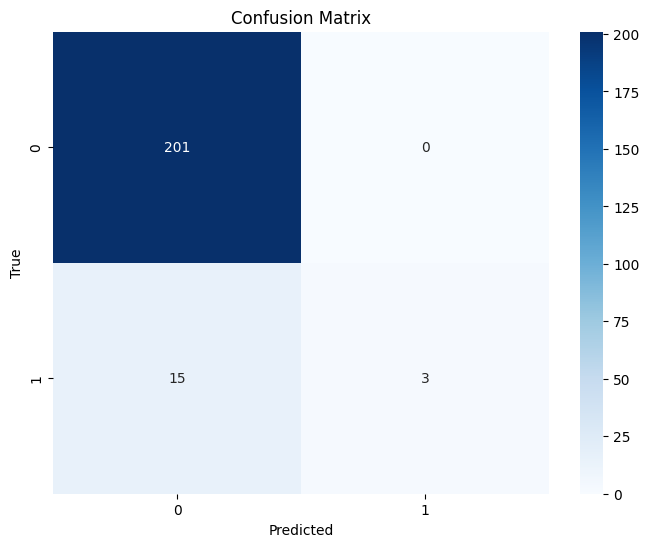

In [9]:
# 7. Avaliação do Modelo no Conjunto de Teste
# Fazendo previsões no conjunto de teste
y_pred = best_model.predict(X_test)

# Imprimindo informações sobre o modelo e sua acurácia
print("RandomForestClassifier com GridSearch")
print(best_model)
print("Accuracy:", accuracy_score(y_test, y_pred))

# Relatório de classificação para avaliar precisão, recall, F1-score, etc.
print("Classification Report:\n", classification_report(y_test, y_pred, zero_division=0))

# Plot da Matriz de Confusão
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

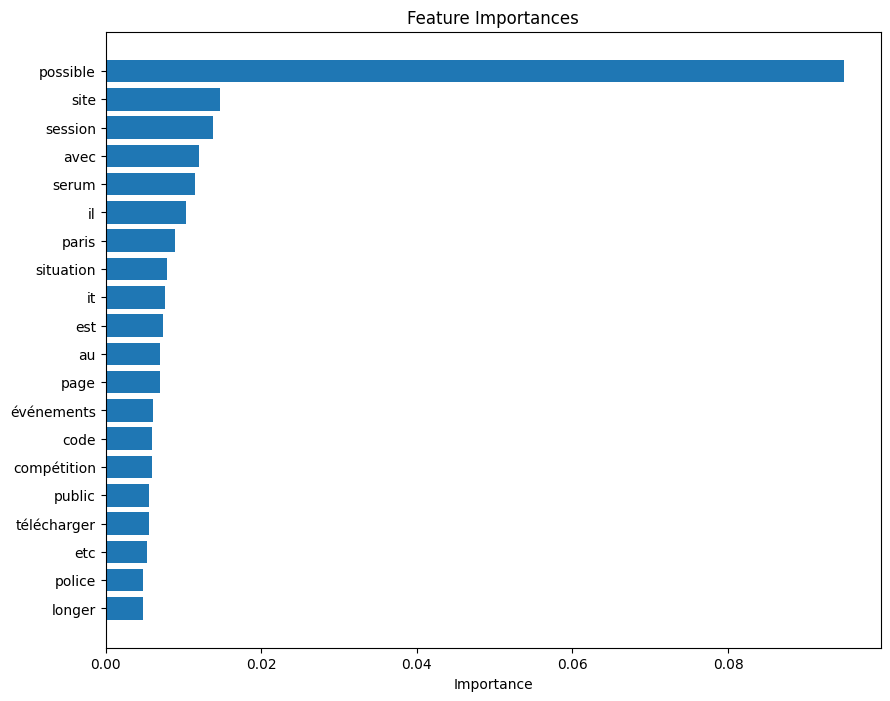

In [10]:
# 8. Avaliação de Importância das Features
# Analisando a importância das features (palavras) para o modelo treinado
importances = best_model.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = tfidf.get_feature_names_out()

# Plotando as 20 features mais importantes
plt.figure(figsize=(10, 8))
plt.title("Feature Importances")
plt.barh(range(20), importances[indices][:20], align="center")
plt.yticks(range(20), [feature_names[i] for i in indices[:20]])
plt.xlabel("Importance")
plt.gca().invert_yaxis()
plt.show()

In [11]:
# 9. Validação Cruzada no Conjunto de Teste
# Utilizando validação cruzada para avaliar a estabilidade do modelo
cv_scores = cross_val_score(best_model, X_test, y_test, cv=5, scoring='f1_macro')
print(f"Cross-Validation F1 Macro: {np.mean(cv_scores):.2f} ± {np.std(cv_scores):.2f}")

Cross-Validation F1 Macro: 0.48 ± 0.00


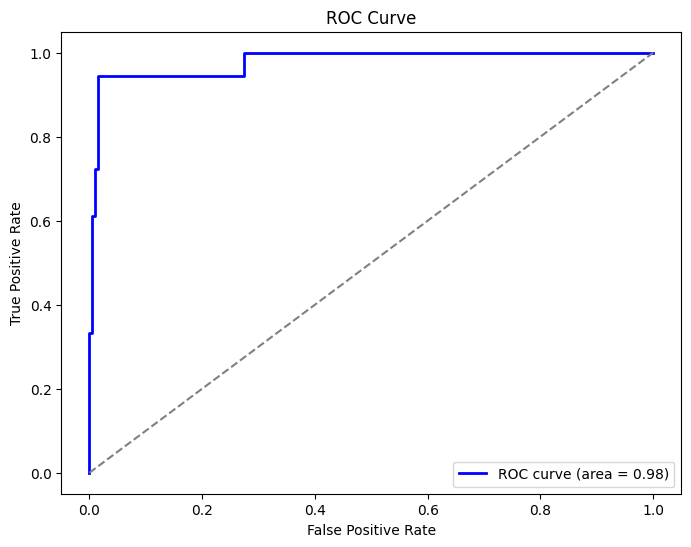

In [12]:
# 10. Curva ROC e AUC
# Avaliando a capacidade de discriminação do modelo com a curva ROC
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba, pos_label='positivo')
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [13]:
# 11. Avaliação do Balanceamento das Classes no Conjunto de Teste
# Verificando a distribuição das classes no conjunto de teste para contexto adicional
print("Distribuição das Classes no Conjunto de Teste:")
print(y_test.value_counts(normalize=True))

Distribuição das Classes no Conjunto de Teste:
sentimento
negativo    0.917808
positivo    0.082192
Name: proportion, dtype: float64
